In [1]:
import os

import numpy as np
import pandas as pd
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

from data import *


SEED = 662
DATA_DIR = "processed"
storage = f"sqlite:///svm.db"

/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings

warnings.filterwarnings("ignore")

data = remove_boring_columns(
    transform_education_levels(
        transform_all_house(combined_transformed_train_with_num_pov)
    )
)
poi = data
nunique = poi.nunique()
cols_to_drop = nunique[nunique == 1].index
poi = poi.drop(cols_to_drop, axis=1)
poi = poi.drop(columns=["edu_q09", "edu_q10", "edu_q11", "edu_q12", "edu_q13"])

X, y, y_binarized = (
    poi.drop(Y_COLUMNS + ["num_pov"], axis=1),
    poi["num_pov"],
    poi[Y_COLUMNS],
)

## linear_svc + kernel_svc


In [8]:
from itertools import combinations
import logging
import sys
import traceback

import lightgbm as lgb
from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsTransformer
from sklearn.pipeline import Pipeline

from models import *


def load_objective(
    X: pd.DataFrame,
    y: pd.DataFrame,
    y_binarized: pd.DataFrame,
    get_trained_model: callable,
):
    X.replace(-999, np.nan, inplace=True)

    def objective(trial: optuna.Trial):
        chi2_threshold = trial.suggest_int("chi2_threshold", 2, 100)
        cv = 3
        imputer_strategy = trial.suggest_categorical(
            "imputer_strategy", ["mean", "median", "most_frequent"]
        )

        train_losses, valid_losses, valid_loss_shift, n_iters = [], [], [], []
        X_train, X_valid, y_train, y_valid, y_train_binarized, y_valid_binarized = (
            train_test_split(X, y, y_binarized, test_size=1 / cv, random_state=SEED)
        )  # lazy, just do 1 round of cv

        # compute pov means aggregated by psu
        aggregated_pov_train_data = pd.concat(
            [X_train["psu_hh_idcode"], y_train], axis=1
        )
        aggregated_pov_train_data[["psu", "hh", "idcode"]] = aggregated_pov_train_data[
            "psu_hh_idcode"
        ].str.split("_", expand=True)
        df_mean = aggregated_pov_train_data.groupby("psu")["num_pov"].mean()
        X_train_means = pd.merge(
            aggregated_pov_train_data,
            df_mean,
            on="psu",
            how="left",
            suffixes=("", "_mean"),
        )["num_pov_mean"]
        X_train_means.replace(np.nan, X_train_means.mean(), inplace=True)

        X_valid[["psu", "hh", "idcode"]] = X_valid["psu_hh_idcode"].str.split(
            "_", expand=True
        )
        X_valid_means = pd.merge(
            X_valid,
            df_mean,
            on="psu",
            how="left",
            suffixes=("", "_mean"),
        )["num_pov"]
        X_valid_means.replace(np.nan, X_valid_means.mean(), inplace=True)
        X_valid_means.rename("num_pov_mean", inplace=True)

        preprocessor = get_preprocessor(
            # ordinal_transformer=Pipeline([("imputer", "passthrough")]),
            imputer_strategy=[
                "most_frequent",
                "most_frequent",
                imputer_strategy,
                imputer_strategy,
            ],
            remainder="drop",
        )

        X_train_processed = preprocessor.fit_transform(X_train)
        selector = SelectPercentile(chi2, percentile=chi2_threshold)
        X_train = selector.fit_transform(X_train_processed, y_train)

        X_valid = preprocessor.transform(X_valid)
        X_valid = selector.transform(X_valid)

        # add pov means to the data
        X_train = np.column_stack([X_train, X_train_means])
        X_valid = np.column_stack([X_valid, X_valid_means])

        # add knn means too
        p = trial.suggest_int("p", 1, 3)
        k_neighbors = trial.suggest_int("k_neighbors", 2, 15)
        transformer = KNeighborsTransformer(
            mode="connectivity", n_neighbors=k_neighbors, p=p
        )
        X_dist_graph = transformer.fit_transform(X_train)
        X_dist_graph.setdiag(0)

        knn_train_means = np.divide(
            (X_dist_graph @ y_train.T), np.asarray(X_dist_graph.sum(axis=1)).flatten()
        )
        np.nan_to_num(knn_train_means, nan=np.nanmean(knn_train_means), copy=False)
        X_train = np.hstack([X_train, knn_train_means.reshape(-1, 1)])
        knn_valid_means = (
            (transformer.kneighbors_graph(X_valid) @ y_train.T) / k_neighbors
        ).reshape(-1, 1)
        np.nan_to_num(knn_valid_means, nan=np.nanmean(knn_train_means), copy=False)
        X_valid = np.hstack([X_valid, knn_valid_means])

        model = get_trained_model(
            trial, seed=SEED, X_train=X_train, y_train=y_train - 1
        )
        train_losses.append(log_loss(y_train_binarized, model.predict_proba(X_train)))

        y_pred = model.predict_proba(X_valid)
        for column_index in [
            column for column in range(10) if column not in model.classes_
        ]:
            y_pred = np.insert(y_pred, column_index - 1, 0, axis=1)

        valid_losses.append(log_loss(y_valid_binarized, y_pred))
        valid_loss_shift.append(valid_losses[-1] - train_losses[-1])
        if hasattr(model, "n_iter_"):
            n_iters.append(model.n_iter_[0])

        mean_valid_loss = np.mean(valid_losses)
        trial.set_user_attr(
            "selected_columns",
            X_train_processed.columns[selector.get_support()].values.tolist(),
        )
        if len(n_iters) > 0:
            trial.set_user_attr("n_iter", np.mean(n_iters))
        trial.set_user_attr("train_loss", np.mean(train_losses))
        trial.set_user_attr("valid_loss_shift", np.mean(valid_loss_shift))
        return mean_valid_loss

    return objective


models = {
    "linear_svc": suggest_linear_svc,
    "kernel_svc": suggest_kernel_svc,
    "random_forest": suggest_random_forest,
}

meta_models = {
    "adaboost": suggest_adaboost,
    "logistic_regression": suggest_logistic_regression,
    "extra_trees": suggest_extra_trees,
}


optuna.logging.set_verbosity(optuna.logging.ERROR)
data = remove_boring_columns(
    transform_education_levels(
        transform_all_house(combined_transformed_train_with_num_pov)
    )
)

poi = data
nunique = poi.nunique()
cols_to_drop = nunique[nunique == 1].index
poi = poi.drop(cols_to_drop, axis=1)
poi = poi.drop(columns=["edu_q09", "edu_q10", "edu_q11", "edu_q12", "edu_q13"])
print(poi.shape)
best_values, best_params = [], []


def get_trained_model(trial, seed, X_train, y_train):
    meta_model_name = trial.suggest_categorical("meta_model", list(meta_models.keys()))
    estimators = [
        (
            model_name,
            models[model_name](trial, max_iter=MAX_ITER, seed=seed),
        )
        for model_name in ("linear_svc", "kernel_svc")
    ]
    clf = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_models[meta_model_name](
            trial, max_iter=MAX_ITER, seed=seed, meta=True
        ),
    ).fit(X_train, y_train)
    return clf


X, y, y_binarized = (
    poi.drop(Y_COLUMNS + ["num_pov"], axis=1),
    poi["num_pov"],
    poi[Y_COLUMNS],
)
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_name = "linear+kernel"
study = optuna.create_study(
    direction="minimize", study_name=study_name, storage=storage, load_if_exists=True
)
# for i in range(200):
#     study.enqueue_trial({"meta_model": "logistic_regression"})
study.optimize(
    load_objective(X, y, y_binarized, get_trained_model),
    n_trials=150,
    n_jobs=-1,
    show_progress_bar=True,
)
best_values.append(study.best_value)
best_params.append(study.best_params)
print(optuna.importance.get_param_importances(study))
print(study.best_trial.user_attrs)
print(best_values), print(best_params)
print("=====================================")
print()

(5337, 83)


Best trial: 378. Best value: 1.71475: 100%|██████████| 150/150 [21:10<00:00,  8.47s/it]


{'meta_model': 0.8937895108650159, 'k_neighbors': 0.04180039838698176, 'chi2_threshold': 0.016138833936532555, 'calibration_method': 0.013191376224948693, 'kernel': 0.009384695240387157, 'kernel_C': 0.00883590497126244, 'linear_C': 0.006179847137546745, 'penalty': 0.0038660947465820545, 'p': 0.003174846029590651, 'imputer_strategy': 0.0025054028698547753, 'intercept_scaling': 0.0011330895912971587}
{'selected_columns': ['binary__house_q02_2.0', 'binary__house_q07_1.0', 'binary__house_q07_2.0', 'binary__house_q11_2.0', 'binary__house_q17_1.0', 'binary__edu_q03_2.0', 'binary__edu_q08_2.0', 'binary__edu_q14_2.0', 'binary__edu_q25_2.0', 'binary__edu_q32_2.0', 'binary__edu_q43_2.0', 'binary__edu_q45_2.0', 'binary__edu_q61_2.0', 'binary__edu_q64_2.0', 'categorical__house_q03_2.0', 'categorical__house_q03_infrequent_sklearn', 'categorical__house_q06_4.0', 'categorical__house_q06_infrequent_sklearn', 'categorical__edu_q17_13.0', 'categorical__edu_q17_infrequent_sklearn', 'categorical__edu_q23_

In [3]:
aggregated_pov_entire_train_data = pd.concat(
    [data["psu_hh_idcode"], data["num_pov"]], axis=1
)
aggregated_pov_entire_train_data[["psu", "hh", "idcode"]] = (
    aggregated_pov_entire_train_data["psu_hh_idcode"].str.split("_", expand=True)
)
df_mean = aggregated_pov_entire_train_data.groupby("psu")["num_pov"].mean()
X_entire_train_mean = pd.merge(
    aggregated_pov_entire_train_data,
    df_mean,
    on="psu",
    how="left",
    suffixes=("", "_mean"),
)["num_pov_mean"]
X_entire_train_mean.replace(np.nan, X_entire_train_mean.mean(), inplace=True)

combined_test[["psu", "hh", "idcode"]] = combined_test["psu_hh_idcode"].str.split(
    "_", expand=True
)
X_test_means = pd.merge(
    combined_test,
    df_mean,
    on="psu",
    how="left",
    suffixes=("", "_mean"),
)["num_pov"]
X_test_means.replace(np.nan, X_test_means.mean(), inplace=True)
X_test_means.rename("num_pov_mean", inplace=True)

0       4.400000
1       4.400000
2       4.400000
3       4.000000
4       4.571429
          ...   
1329    4.400000
1330    5.142857
1331    5.200000
1332    5.200000
1333    5.200000
Name: num_pov_mean, Length: 1334, dtype: float64

In [19]:
from sklearn.feature_selection import SelectPercentile, chi2


def get_trained_model(trial, seed, X_train, y_train):
    meta_model_name = trial.suggest_categorical("meta_model", list(meta_models.keys()))
    estimators = [
        (
            model_name,
            models[model_name](trial, max_iter=MAX_ITER * 10, seed=seed),
        )
        for model_name in ("linear_svc", "kernel_svc")
    ]
    clf = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_models[meta_model_name](
            trial, max_iter=MAX_ITER * 10, seed=seed, meta=True
        ),
    ).fit(X_train, y_train)
    return clf


linear_kernel_study = optuna.load_study(study_name="linear+kernel", storage=storage)
linear_kernel_best_trial = linear_kernel_study.best_trial
chi2_threshold = linear_kernel_best_trial.params["chi2_threshold"]
imputer_strategy = linear_kernel_best_trial.params["imputer_strategy"]
preprocessor = get_preprocessor(
    imputer_strategy=[
        "most_frequent",
        "most_frequent",
        imputer_strategy,
        imputer_strategy,
    ],
    remainder="drop",
)
X_processed = preprocessor.fit_transform(X)
selector = SelectPercentile(chi2, percentile=chi2_threshold)
X_selected = selector.fit_transform(X_processed, y)
X_selected = np.column_stack([X_selected, X_entire_train_mean])

linear_kernel_p = linear_kernel_best_trial.params["p"]
linear_kernel_k_neighbors = linear_kernel_best_trial.params["k_neighbors"]
transformer = KNeighborsTransformer(
    mode="connectivity", n_neighbors=linear_kernel_k_neighbors, p=linear_kernel_p
)
X_dist_graph = transformer.fit_transform(X_selected)
X_dist_graph.setdiag(0)
knn_train_means = np.divide(
    (X_dist_graph @ y.T), np.asarray(X_dist_graph.sum(axis=1)).flatten()
)
np.nan_to_num(knn_train_means, nan=np.nanmean(knn_train_means), copy=False)
X_selected = np.hstack([X_selected, knn_train_means.reshape(-1, 1)])

final_model = get_trained_model(linear_kernel_best_trial, SEED, X_selected, y - 1)
final_y_train_pred = final_model.predict_proba(X_selected)

log_loss(y_binarized, final_y_train_pred)

1.5348127090197885

<Axes: >

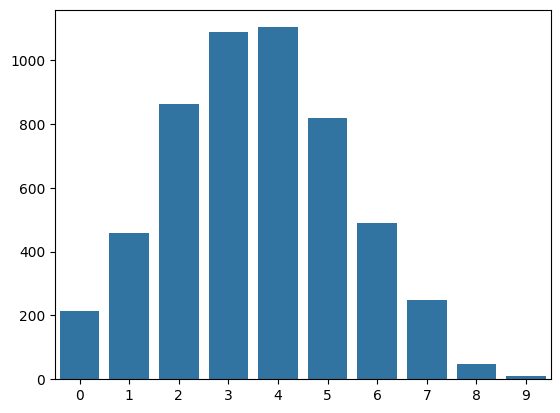

In [20]:
import seaborn as sns

sns.barplot(final_y_train_pred.sum(axis=0))

Submission file saved as linear+kernel-1.csv


<Axes: >

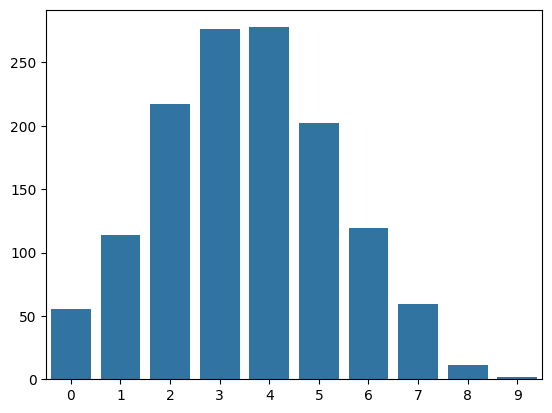

In [35]:
from data import generate_submission

X_submissions = remove_boring_columns(
    transform_education_levels(transform_all_house(combined_transformed_test))
)
X_submissions.replace(-999, np.nan, inplace=True)
X_submissions_scaled = preprocessor.transform(X_submissions)
X_submissions_scaled = selector.transform(X_submissions_scaled)
X_submissions_scaled = np.column_stack([X_submissions_scaled, X_test_means])

knn_test_dist_graph = transformer.kneighbors_graph(X_submissions_scaled)
knn_test_means = (
    (transformer.kneighbors_graph(X_submissions_scaled) @ y.T)
    / np.asarray(knn_test_dist_graph.sum(axis=1)).flatten()
).reshape(-1, 1)
np.nan_to_num(knn_test_means, nan=np.nanmean(knn_train_means), copy=False)

X_submissions_scaled = np.column_stack([X_submissions_scaled, knn_test_means])
final_y_submission_pred = final_model.predict_proba(X_submissions_scaled)

generate_submission(final_y_submission_pred, "linear+kernel")
sns.barplot(final_y_submission_pred.sum(axis=0))

## linear_svc + random_forest


In [ ]:
from itertools import combinations
import logging
import sys
import traceback

from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsTransformer
from sklearn.pipeline import Pipeline

from models import *


def load_objective(
    X: pd.DataFrame,
    y: pd.DataFrame,
    y_binarized: pd.DataFrame,
    get_trained_model: callable,
):
    X.replace(-999, np.nan, inplace=True)

    def objective(trial: optuna.Trial):
        chi2_threshold = trial.suggest_int("chi2_threshold", 2, 100)
        cv = 3
        imputer_strategy = trial.suggest_categorical(
            "imputer_strategy", ["mean", "median", "most_frequent"]
        )

        train_losses, valid_losses, valid_loss_shift, n_iters = [], [], [], []
        X_train, X_valid, y_train, y_valid, y_train_binarized, y_valid_binarized = (
            train_test_split(X, y, y_binarized, test_size=1 / cv, random_state=SEED)
        )  # lazy, just do 1 round of cv

        # compute pov means aggregated by psu
        aggregated_pov_train_data = pd.concat(
            [X_train["psu_hh_idcode"], y_train], axis=1
        )
        aggregated_pov_train_data[["psu", "hh", "idcode"]] = aggregated_pov_train_data[
            "psu_hh_idcode"
        ].str.split("_", expand=True)
        df_mean = aggregated_pov_train_data.groupby("psu")["num_pov"].mean()
        X_train_means = pd.merge(
            aggregated_pov_train_data,
            df_mean,
            on="psu",
            how="left",
            suffixes=("", "_mean"),
        )["num_pov_mean"]
        X_train_means.replace(np.nan, X_train_means.mean(), inplace=True)

        X_valid[["psu", "hh", "idcode"]] = X_valid["psu_hh_idcode"].str.split(
            "_", expand=True
        )
        X_valid_means = pd.merge(
            X_valid,
            df_mean,
            on="psu",
            how="left",
            suffixes=("", "_mean"),
        )["num_pov"]
        X_valid_means.replace(np.nan, X_valid_means.mean(), inplace=True)
        X_valid_means.rename("num_pov_mean", inplace=True)

        preprocessor = get_preprocessor(
            # ordinal_transformer=Pipeline([("imputer", "passthrough")]),
            imputer_strategy=[
                "most_frequent",
                "most_frequent",
                imputer_strategy,
                imputer_strategy,
            ],
            remainder="drop",
        )

        X_train_processed = preprocessor.fit_transform(X_train)
        selector = SelectPercentile(chi2, percentile=chi2_threshold)
        X_train = selector.fit_transform(X_train_processed, y_train)

        X_valid = preprocessor.transform(X_valid)
        X_valid = selector.transform(X_valid)

        # add pov means to the data
        X_train = np.column_stack([X_train, X_train_means])
        X_valid = np.column_stack([X_valid, X_valid_means])

        # add knn means too
        p = trial.suggest_int("p", 1, 3)
        k_neighbors = trial.suggest_int("k_neighbors", 2, 15)
        transformer = KNeighborsTransformer(
            mode="connectivity", n_neighbors=k_neighbors, p=p
        )
        X_dist_graph = transformer.fit_transform(X_train)
        X_dist_graph.setdiag(0)

        knn_train_means = np.divide(
            (X_dist_graph @ y_train.T), np.asarray(X_dist_graph.sum(axis=1)).flatten()
        )
        np.nan_to_num(knn_train_means, nan=np.nanmean(knn_train_means), copy=False)
        X_train = np.hstack([X_train, knn_train_means.reshape(-1, 1)])
        knn_valid_means = (
            (transformer.kneighbors_graph(X_valid) @ y_train.T) / k_neighbors
        ).reshape(-1, 1)
        np.nan_to_num(knn_valid_means, nan=np.nanmean(knn_train_means), copy=False)
        X_valid = np.hstack([X_valid, knn_valid_means])

        model = get_trained_model(
            trial, seed=SEED, X_train=X_train, y_train=y_train - 1
        )
        train_losses.append(log_loss(y_train_binarized, model.predict_proba(X_train)))

        y_pred = model.predict_proba(X_valid)
        for column_index in [
            column for column in range(10) if column not in model.classes_
        ]:
            y_pred = np.insert(y_pred, column_index - 1, 0, axis=1)

        valid_losses.append(log_loss(y_valid_binarized, y_pred))
        valid_loss_shift.append(valid_losses[-1] - train_losses[-1])
        if hasattr(model, "n_iter_"):
            n_iters.append(model.n_iter_[0])

        mean_valid_loss = np.mean(valid_losses)
        trial.set_user_attr(
            "selected_columns",
            X_train_processed.columns[selector.get_support()].values.tolist(),
        )
        if len(n_iters) > 0:
            trial.set_user_attr("n_iter", np.mean(n_iters))
        trial.set_user_attr("train_loss", np.mean(train_losses))
        trial.set_user_attr("valid_loss_shift", np.mean(valid_loss_shift))
        return mean_valid_loss

    return objective


models = {
    "linear_svc": suggest_linear_svc,
    "kernel_svc": suggest_kernel_svc,
    "random_forest": suggest_random_forest,
}

meta_models = {
    "adaboost": suggest_adaboost,
    "logistic_regression": suggest_logistic_regression,
    "extra_trees": suggest_extra_trees,
}


optuna.logging.set_verbosity(optuna.logging.ERROR)
data = remove_boring_columns(
    transform_education_levels(
        transform_all_house(combined_transformed_train_with_num_pov)
    )
)

poi = data
nunique = poi.nunique()
cols_to_drop = nunique[nunique == 1].index
poi = poi.drop(cols_to_drop, axis=1)
poi = poi.drop(columns=["edu_q09", "edu_q10", "edu_q11", "edu_q12", "edu_q13"])
print(poi.shape)
best_values, best_params = [], []


def get_trained_model(trial, seed, X_train, y_train):
    meta_model_name = trial.suggest_categorical("meta_model", meta_models.keys())
    estimators = [
        (
            model_name,
            models[model_name](trial, max_iter=MAX_ITER, seed=seed),
        )
        for model_name in ("linear_svc", "random_forest")
    ]
    clf = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_models[meta_model_name](
            trial, max_iter=MAX_ITER, seed=seed, meta=True
        ),
    ).fit(X_train, y_train)
    return clf


X, y, y_binarized = (
    poi.drop(Y_COLUMNS + ["num_pov"], axis=1),
    poi["num_pov"],
    poi[Y_COLUMNS],
)
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_name = "linear+random_forest"
study = optuna.create_study(
    direction="minimize", study_name=study_name, storage=storage, load_if_exists=True
)
study.optimize(
    load_objective(X, y, y_binarized, get_trained_model),
    n_trials=200,
    n_jobs=-1,
    show_progress_bar=True,
)
best_values.append(study.best_value)
best_params.append(study.best_params)
print(optuna.importance.get_param_importances(study))
print(study.best_trial.user_attrs)
print(best_values), print(best_params)
print("=====================================")
print()

(5337, 83)


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsTransformer

from models import *

models = {
    "linear_svc": suggest_linear_svc,
    "kernel_svc": suggest_kernel_svc,
    "random_forest": suggest_random_forest,
}

meta_models = {
    "adaboost": suggest_adaboost,
    "logistic_regression": suggest_logistic_regression,
    "extra_trees": suggest_extra_trees,
}


def get_trained_model(trial, seed, X_train, y_train):
    meta_model_name = trial.suggest_categorical("meta_model", list(meta_models.keys()))
    estimators = [
        (
            model_name,
            models[model_name](trial, max_iter=MAX_ITER * 10, seed=seed),
        )
        for model_name in ("linear_svc", "random_forest")
    ]
    clf = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_models[meta_model_name](
            trial, max_iter=MAX_ITER * 10, seed=seed, meta=True
        ),
    ).fit(X_train, y_train)
    return clf


linear_kernel_study = optuna.load_study(
    study_name="linear+random_forest", storage=storage
)
linear_kernel_best_trial = linear_kernel_study.best_trial
chi2_threshold = linear_kernel_best_trial.params["chi2_threshold"]
imputer_strategy = linear_kernel_best_trial.params["imputer_strategy"]
preprocessor = get_preprocessor(
    imputer_strategy=[
        "most_frequent",
        "most_frequent",
        imputer_strategy,
        imputer_strategy,
    ],
    remainder="drop",
)
X_processed = preprocessor.fit_transform(X)
selector = SelectPercentile(chi2, percentile=chi2_threshold)
X_selected = selector.fit_transform(X_processed, y)
X_selected = np.column_stack([X_selected, X_entire_train_mean])

linear_kernel_p = linear_kernel_best_trial.params["p"]
linear_kernel_k_neighbors = linear_kernel_best_trial.params["k_neighbors"]
transformer = KNeighborsTransformer(
    mode="connectivity", n_neighbors=linear_kernel_k_neighbors, p=linear_kernel_p
)
X_dist_graph = transformer.fit_transform(X_selected)
X_dist_graph.setdiag(0)
knn_train_means = np.divide(
    (X_dist_graph @ y.T), np.asarray(X_dist_graph.sum(axis=1)).flatten()
)
np.nan_to_num(knn_train_means, nan=np.nanmean(knn_train_means), copy=False)
X_selected = np.hstack([X_selected, knn_train_means.reshape(-1, 1)])

final_model = get_trained_model(linear_kernel_best_trial, SEED, X_selected, y - 1)
final_y_train_pred = final_model.predict_proba(X_selected)

print(log_loss(y_binarized, final_y_train_pred))

1.5020907722721972


NameError: name 'sns' is not defined

<Axes: >

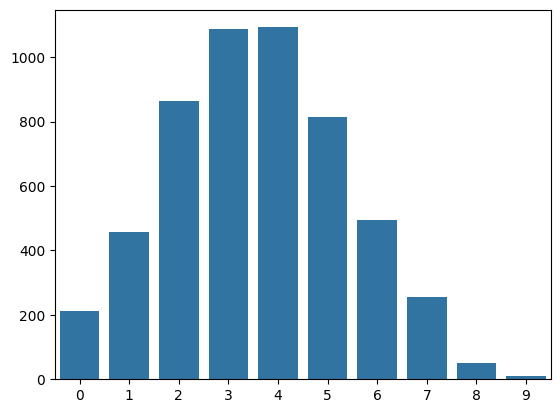

In [ ]:
import seaborn as sns

sns.barplot(final_y_train_pred.sum(axis=0))

Submission file saved as linear+random_forest-1.csv


<Axes: >

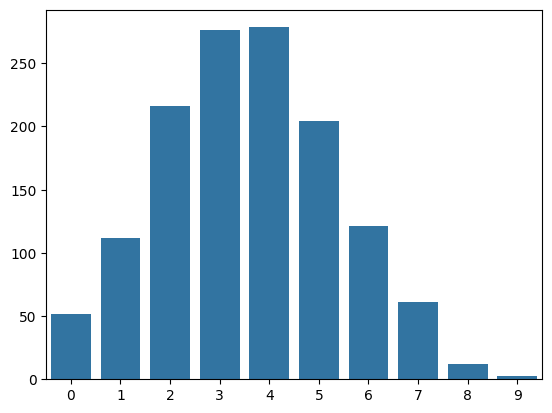

In [6]:
from data import generate_submission

X_submissions = remove_boring_columns(
    transform_education_levels(transform_all_house(combined_transformed_test))
)
X_submissions.replace(-999, np.nan, inplace=True)
X_submissions_scaled = preprocessor.transform(X_submissions)
X_submissions_scaled = selector.transform(X_submissions_scaled)
X_submissions_scaled = np.column_stack([X_submissions_scaled, X_test_means])

knn_test_dist_graph = transformer.kneighbors_graph(X_submissions_scaled)
knn_test_means = (
    (transformer.kneighbors_graph(X_submissions_scaled) @ y.T)
    / np.asarray(knn_test_dist_graph.sum(axis=1)).flatten()
).reshape(-1, 1)
np.nan_to_num(knn_test_means, nan=np.nanmean(knn_train_means), copy=False)

X_submissions_scaled = np.column_stack([X_submissions_scaled, knn_test_means])
final_y_submission_pred = final_model.predict_proba(X_submissions_scaled)

generate_submission(final_y_submission_pred, "linear+random_forest")
sns.barplot(final_y_submission_pred.sum(axis=0))